In [2]:
%matplotlib inline
import sys
sys.path.append('../')
import tables as tb
import h5py
import numpy as np
import pandas as pd
from datetime import datetime
import scipy.sparse as sp
import matplotlib.pyplot as plt
import sqlite3 as lite
from tools import OHLC, Density
from tools import open_file, products

### 일별 OHLC 변환하여 TDOP (Trade Density On Price) 만들기 

In [3]:
filters = tb.Filters(complib='blosc', complevel=9)
raw_data = open_file('h5py', 'raw data/daily_futures.h5', mode='r')

In [4]:
tdop = tb.open_file('../data/raw data/density.hdf5', mode='w', filters=filters)

In [5]:
#종목정보 불러오기
pinfo = products()

In [6]:
for cnt, file in enumerate(raw_data.values()):
    #if cnt == 1:
    #    break
    
    symbol = file.attrs['symbol']
    name = file.attrs['name']
    source = file.value[:,[0,2,3,5]] #date,high,low,volume
    
    if symbol == 'None':
        continue
    
    print('\r %s (%s/%s)'%(name,cnt,len(raw_data)), end='', flush=True)

    #pytables cursor
    group = tdop.create_group('/', symbol, name)
    density = tdop.create_table(group, 'Density', Density)
    
    data = []
    #환경변수
    tick_unit = pinfo[symbol]['tick_unit']
    digit = pinfo[symbol]['decimal_places']
    
    #pandas dataframe
    #df = pd.DataFrame(group.Daily.read()).sort_values('date', ascending=True)
    
    for date, high, low, volume in source:
        
        if round(low, digit) == round(high, digit):
            #continue #일봉에서 고가 == 저가 이면 문제 있는 데이터임. 버림.
            data.append((date, round(low, digit), volume))
        
        else:
            length = (high - low)/tick_unit + 1
            length = np.rint(length)
            value = volume/length
            
            if np.isinf(value) or (value < 0.1): #inf 또는 틱탕 너무 작은 value 버림
                #print("wrong volume", row.volume, length, name, str(row.date.astype('M8[s]').astype('M8[D]')))
                continue
            else:
                for price in np.arange(round(low, digit), high-tick_unit/2, tick_unit):
                    data.append((date, price, value))
    if data:
        density.append(data)
        density.flush()
print("\nEverythin fin.")

 ICE Russell 2000 Index Mini (63/77)7)
Everythin fin.


In [25]:
tdop.close()

### Verification

In [10]:
# 중복데이터 체크
from collections import Counter

for grp in tdop.iter_nodes('/'):
    item = grp.Density.read()
    print()

TypeError: unhashable type: 'writeable void-scalar'

In [15]:
tdop.close()

In [11]:
data = raw_data['CME_AD'].value

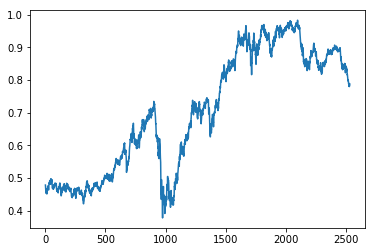

In [12]:
plt.plot(data[:,1])